# Virginia Council — Membership Analysis (starter)

**Goal:** quick baseline on membership levels and growth.

**Data:** Neon CRM export (all levels, all statuses, all time) saved as  
`../data/membership/memberships_alltime_YYYY-MM-DD.csv`

**This notebook creates:**
- Plot A: *New members per month × level* (last 18 months)
- Plot B: *Active mix by level (current)*

Figures are saved under `../reports/figures/`.


In [2]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# file path — update just the filename
DATA_PATH = "../data/membership/allmembers.csv"

# ensure output dir exists
OUT_DIR = "../reports/figures"
os.makedirs(OUT_DIR, exist_ok=True)

# helpers
def parse_dt(x):
    return pd.to_datetime(x, errors="coerce", infer_datetime_format=True)

def norm_zip5(s):
    if pd.isna(s): return None
    s = re.sub(r"\D", "", str(s))  # keep digits only
    return s.zfill(5)[:5] if s else None


In [3]:
df = pd.read_csv(DATA_PATH, dtype=str, low_memory=False)

# make a quick column lookup (case-insensitive)
lower = {c.lower(): c for c in df.columns}

def pick(*names):
    for n in names:
        if n in lower:
            return lower[n]
    return None

COL_ACCOUNT = pick("account id","member id","contact id","id")
COL_EMAIL   = pick("email","primary email")
COL_LEVEL   = pick("membership level","level","plan","tier")
COL_STATUS  = pick("status","membership status")
COL_CREATED = pick("created on","created date","join date","start date","member since")
COL_EXPIRE  = pick("expiration date","expire date","end date","expires on","renewal date")
COL_ZIP     = pick("zip","zip code","postal code")
COL_AMOUNT  = pick("amount","dues","price","fee","amount paid")

# basic normalization (optional columns guarded)
if COL_CREATED:
    df["CREATED_DT"] = parse_dt(df[COL_CREATED])
if COL_EXPIRE:
    df["EXPIRE_DT"] = parse_dt(df[COL_EXPIRE])
if COL_ZIP:
    df["ZIP5"] = df[COL_ZIP].map(norm_zip5)
if COL_EMAIL:
    df["EMAIL_NORM"] = df[COL_EMAIL].str.strip().str.lower()

# show quick schema preview
print(f"Rows: {len(df):,}  |  Columns: {len(df.columns)}")
print("Detected columns:")
print({
    "ACCOUNT": COL_ACCOUNT,
    "EMAIL": COL_EMAIL,
    "LEVEL": COL_LEVEL,
    "STATUS": COL_STATUS,
    "CREATED": COL_CREATED,
    "EXPIRE": COL_EXPIRE,
    "ZIP": COL_ZIP,
    "AMOUNT": COL_AMOUNT,
})

df.head(8)


Rows: 171  |  Columns: 15
Detected columns:
{'ACCOUNT': 'Account ID', 'EMAIL': None, 'LEVEL': 'Membership Level', 'STATUS': 'Status', 'CREATED': 'Created On', 'EXPIRE': None, 'ZIP': None, 'AMOUNT': 'Amount'}


C:\Users\sheila\AppData\Local\Temp\ipykernel_9908\778571706.py:16: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(x, errors="coerce", infer_datetime_format=True)


,Account,Account ID,Amount,Payment,Created On,Membership Level,Term,Number of Sub-members,Primary Member,Starts on,Ends on,Notes,Status,Unnamed: 13,CREATED_DT
0,Carey Clements,12548,0.0,NaN,10/27/2025,Freedom Membership,Freedom Membership (Renew),NaN,NaN,10/27/2025,10/26/2026,NaN,Succeeded,NaN,2025-10-27
1,Cheryl Long,14049,0.0,NaN,10/26/2025,Freedom Membership,Freedom Membership,NaN,NaN,10/26/2025,10/25/2026,NaN,Succeeded,NaN,2025-10-26
2,Di ABERNATHY,12543,1000.0,Credit Card (Online),10/24/2025,President’s Council Membership,President’s Council Member (Renew),NaN,NaN,10/24/2025,10/23/2026,NaN,Succeeded,NaN,2025-10-24
3,Sonja Myers,12514,0.0,NaN,10/23/2025,Freedom Membership,Freedom Membership (Renew),NaN,NaN,10/23/2025,10/22/2026,NaN,Succeeded,NaN,2025-10-23
4,Susan Zamecnik,12585,1000.0,Credit Card (Online),10/23/2025,President’s Council Membership,President’s Council Member (Renew),NaN,NaN,10/23/2025,10/22/2026,NaN,Succeeded,NaN,2025-10-23
5,Percy Mansfield,12426,0.0,NaN,10/21/2025,Freedom Membership,Freedom Membership (Renew),NaN,NaN,10/21/2025,10/20/2026,NaN,Succeeded,NaN,2025-10-21
6,Peggy Hedblom,6062,0.0,NaN,10/21/2025,Freedom Membership,Freedom Membership (Renew),NaN,NaN,10/21/2025,10/20/2026,NaN,Succeeded,NaN,2025-10-21
7,Richard Hicks,12418,0.0,NaN,10/20/2025,Freedom Membership,Freedom Membership (Renew),NaN,NaN,10/20/2025,10/19/2026,NaN,Succeeded,NaN,2025-10-20


<Figure size 1100x500 with 0 Axes>

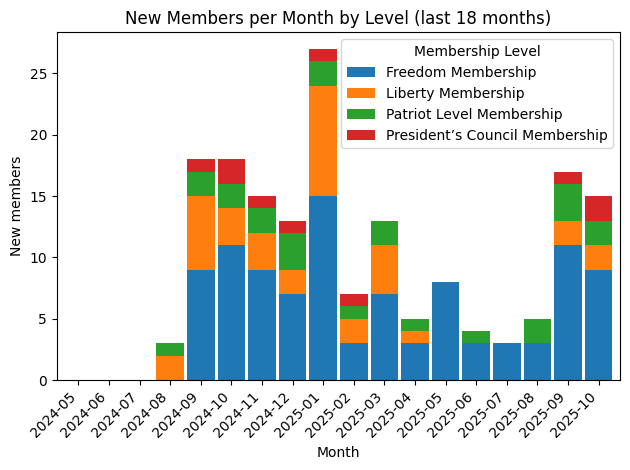

Saved: ../reports/figures\new_members_by_month_level.png


In [4]:
assert "CREATED_DT" in df.columns and COL_LEVEL, "Need CREATED_DT and LEVEL columns."

# group monthly
d = df.dropna(subset=["CREATED_DT"]).copy()
d["YYYYMM"] = d["CREATED_DT"].dt.to_period("M").astype(str)

monthly_level = (
    d.groupby(["YYYYMM", df[COL_LEVEL].fillna("Unknown")])
     .size().rename("COUNT").reset_index()
)

# keep last 18 months
last_months = (pd.Period(d["CREATED_DT"].max(), "M")
               if not d["CREATED_DT"].isna().all()
               else pd.Period(pd.Timestamp.today(), "M"))
months = pd.period_range(last_months - 17, last_months, freq="M").astype(str)
plot_df = (monthly_level
           .pivot(index="YYYYMM", columns=COL_LEVEL, values="COUNT")
           .reindex(months).fillna(0))

# plot
plt.figure(figsize=(11, 5))
plot_df.plot(kind="bar", stacked=True, width=0.9)
plt.title("New Members per Month by Level (last 18 months)")
plt.xlabel("Month")
plt.ylabel("New members")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# save
fig_path = os.path.join(OUT_DIR, "new_members_by_month_level.png")
plt.savefig(fig_path, dpi=160, bbox_inches="tight")
plt.show()

print("Saved:", fig_path)


Status sample (first ~15 unique): ['failed', 'succeeded']
No 'Active' rows found by Status or Expiration — showing overall membership by level.


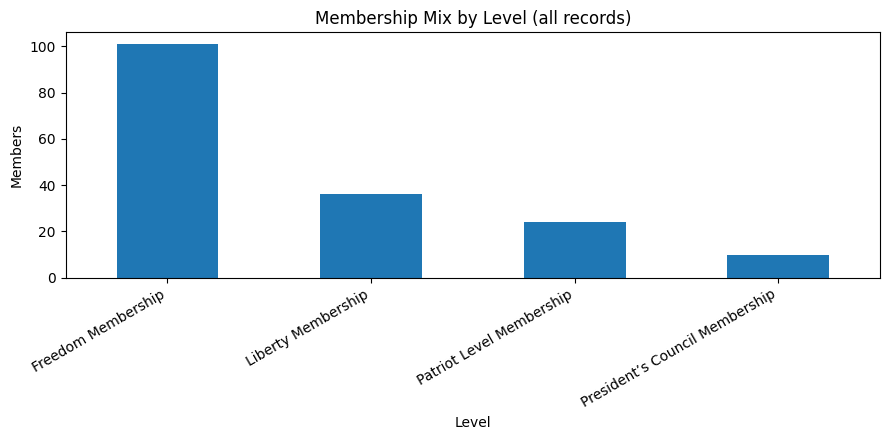

Total counted: 171
Saved: ../reports/figures\membership_mix_by_level_all.png


,SHARE_%
Membership Level,
Freedom Membership,59.1
Liberty Membership,21.1
Patriot Level Membership,14.0
President’s Council Membership,5.8


In [6]:
# === Replacement Cell 5 — robust active detection with safe fallback ===
assert COL_LEVEL, "Need LEVEL column."

# Peek at your Status values to understand what's in the data
if COL_STATUS:
    status_series = df[COL_STATUS].astype(str).str.strip().str.lower()
    print("Status sample (first ~15 unique):",
          sorted(status_series.dropna().unique())[:15])
else:
    status_series = pd.Series([], dtype="object")

# Consider these as "active"-like statuses
ACTIVE_TOKENS = {"active", "current", "renewed"}

active_mask = pd.Series(False, index=df.index)
if COL_STATUS:
    active_mask = status_series.isin(ACTIVE_TOKENS) | status_series.str.contains(r"\bactive\b", na=False)

# If no active rows found via Status, try inferring via expiration date if available
if not active_mask.any() and "EXPIRE_DT" in df.columns:
    today = pd.Timestamp.today().normalize()
    active_mask = df["EXPIRE_DT"].notna() & (df["EXPIRE_DT"] >= today)

# Choose what to plot: active mix if possible, otherwise overall mix
if active_mask.any():
    series = (df.loc[active_mask]
                .groupby(df[COL_LEVEL].fillna("Unknown")).size()
                .sort_values(ascending=False).rename("COUNT"))
    title = "Active Membership Mix by Level (current)"
    out_name = "active_mix_by_level.png"
else:
    print("No 'Active' rows found by Status or Expiration — showing overall membership by level.")
    series = (df.groupby(df[COL_LEVEL].fillna("Unknown")).size()
                .sort_values(ascending=False).rename("COUNT"))
    title = "Membership Mix by Level (all records)"
    out_name = "membership_mix_by_level_all.png"

# Plot safely if we have any data
if series.empty:
    print("Nothing to plot: no level values present.")
else:
    plt.figure(figsize=(9, 4.5))
    series.plot(kind="bar")
    plt.title(title)
    plt.xlabel("Level")
    plt.ylabel("Members")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()

    fig_path = os.path.join(OUT_DIR, out_name)
    plt.savefig(fig_path, dpi=160, bbox_inches="tight")
    plt.show()

    total = int(series.sum())
    print(f"Total counted: {total}")
    print("Saved:", fig_path)

    # Quick table with shares
    series_pct = (series / series.sum() * 100).round(1).rename("SHARE_%").to_frame()
    display(series_pct)


### Takeaways (draft)
- [ ] Level(s) driving most new joins in the last 3–6 months:
- [ ] Any months with unusual spikes/dips:
- [ ] Current active mix skew (who dominates):
- [ ] Next questions: renewals by level, Central-VA coverage, source quality.
